In [1]:
import sys
sys.path.append("../") # go to parent dir

import jax
import jax.numpy as jnp
import numpy as np
from matplotlib import pyplot as plt
import module.chebyshev_solver as chb

import optax
from tqdm import tqdm

In [3]:
key = jax.random.PRNGKey(0)

## 1. Problem
In this notebook we try to find the position and size of a guassian conductivity blob by giving the dirichlet and von-Neumann boundary conditions. We solve the heat equation:

$$
\nabla(k\,\nabla T) = 0
$$

The conductivity k will be modeled by exponentially decaying chebyshev coefficients.

In [9]:
solver = chb.Solver(N = 40)
xx = solver.xx
yy = solver.yy
grid = solver.grid
dims = (solver.N, solver.N)
mask = np.ones(dims)
mask[1:-1,1:-1] = 0
maskx = np.ones(dims)
maskx[:,1:-1] = 0
masky = np.ones(dims)
masky[1:-1,:] = 0
mask = jnp.array(mask)
ii, jj = jnp.meshgrid(jnp.arange(solver.N), jnp.arange(solver.N))
a = 0.7
index_decay = jnp.exp(-(ii+jj)/a)

k_cheby_init = jax.random.normal(key, shape = dims) * index_decay
k_cheby_init = k_cheby_init.at[0,0].set(k_cheby_init[0,0] + jnp.sum(index_decay)*2)
k_cheby_init = k_cheby_init.flatten()
k_init = (solver.I @ k_cheby_init).reshape(dims)

key, _ = jax.random.split(key)

dirichlet_cheby = jax.random.normal(key, shape = dims) * index_decay
dirichlet = (solver.I @ dirichlet_cheby.flatten()).reshape(dims)
dirichlet *= mask

target_solution = solver.solve(k_cheby_init, dirichlet)

@jax.jit
def get_neumann(solution):
    jx = (solution["dx T"] * solution["k"]).reshape(dims)
    jy = (solution["dy T"] * solution["k"]).reshape(dims)

    neumann = jnp.concatenate((jx[:,0], jy[-1,:], jx[:,-1], jy[0,:]), axis = 0)
    return neumann

@jax.jit
def distance(solution, target_solution):
    neumann = get_neumann(solution)
    target_neumann = get_neumann(target_solution)

    return jnp.sum((neumann - target_neumann)**2)

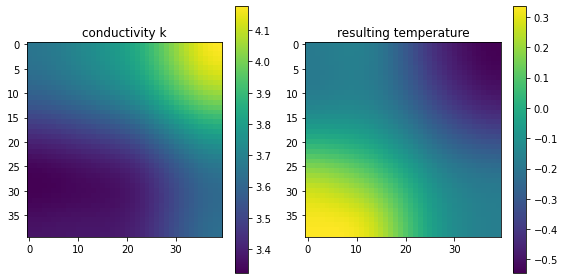

In [10]:
fig, axs = plt.subplots(1, 2, figsize = (8,4))
im1 = axs[0].imshow(target_solution["k"].reshape(dims))
plt.colorbar(im1, ax = axs[0])
axs[0].set_title("conductivity k")
im2 = axs[1].imshow(target_solution["T"].reshape(dims))
plt.colorbar(im2, ax = axs[1])
axs[1].set_title("resulting temperature")

fig.tight_layout()

Text(0.5, 1.0, 'Neumann boundary')

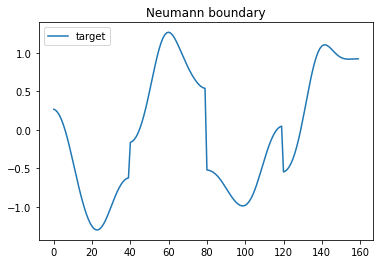

In [12]:
plt.plot(get_neumann(target_solution), label = "target")

plt.legend()
plt.title("Neumann boundary")

## 2. Initialise variational parameters

In [13]:
k_cheby = jax.random.normal(key, shape = dims) * index_decay
k_cheby = k_cheby.at[0,0].set(k_cheby[0,0] + jnp.sum(index_decay))

k_param = {"coeff":k_cheby}

In [14]:
@jax.jit
def get_solution(k_param):
    k_cheby = k_param["coeff"] * index_decay
    k_cheby = k_cheby.flatten()
    solution = solver.solve(k_cheby, dirichlet)
    return solution

## 3. Optimize parameters

In [15]:
@jax.jit
def loss(k_param):
    return distance(get_solution(k_param), target_solution)

g = jax.value_and_grad(loss)

In [16]:
# define
optimizer = optax.adam(learning_rate=0.05)

# initialise
optimizer_state = optimizer.init(k_param)

err = []

In [28]:
for i in tqdm(range(10)):
    val, grad = g(k_param)
    err.append(val)

    updates, optimizer_state = optimizer.update(grad, optimizer_state, k_param)

    k_param = optax.apply_updates(k_param, updates)

100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


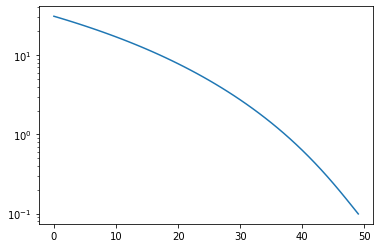

In [29]:
plt.plot(err)
plt.yscale("log")

Text(0.5, 1.0, 'Neumann boundary')

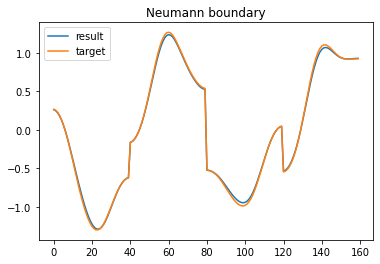

In [30]:
plt.plot(get_neumann(get_solution(k_param)), label = "result")
plt.plot(get_neumann(target_solution), label ="target")

plt.legend()
plt.title("Neumann boundary")

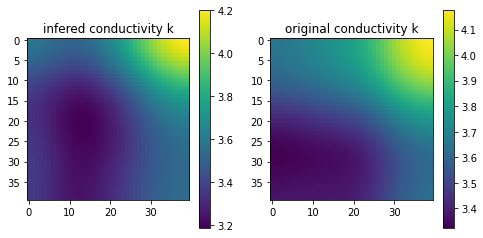

In [33]:
result = get_solution(k_param)
fig, axs = plt.subplots(1, 2, figsize = (8,4))
im1 = axs[0].imshow(result["k"].reshape(dims))
axs[0].set_title("infered conductivity k")
im2 = axs[1].imshow(target_solution["k"].reshape(dims))
axs[1].set_title("original conductivity k")
plt.colorbar(im1, ax = axs[0])
plt.colorbar(im2, ax = axs[1])